# Reinforcement Learning

# 3. Online evaluation

This notebook presents the online evaluation of a policy by **Monte-Carlo learning** and **TD learning**.


In [177]:
import sys
from pathlib import Path

lib_path = str(Path.cwd().parent)

if lib_path not in sys.path:
    sys.path.append(lib_path)
print(sys.path)

['C:\\Python312\\python312.zip', 'C:\\Python312\\DLLs', 'C:\\Python312\\Lib', 'C:\\Python312', 'd:\\Code\\Reinforcement Learning\\venv', '', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\win32', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\win32\\lib', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\Pythonwin', 'd:\\Code\\Reinforcement Learning']


In [178]:
import numpy as np
import matplotlib.pyplot as plt

In [179]:
from lib.model import Maze, Walk, TicTacToe, Nim, ConnectFour
from lib.agent import Agent, OnlineEvaluation
from lib.dynamic import PolicyEvaluation

## To do:


- Complete the class `MCLearning` and test it on the random walk.
- Compare with the exact solution obtained by Dynamic Programming.<br> You might plot the [Spearman's correlation](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) between both value functions with respect to the training time.
- Do the same with `TDLearning`.


## Monte-Carlo learning:


In [180]:
class MCLearning(OnlineEvaluation):
    """Online evaluation by Monte-Carlo."""

    def update_values(self, state=None, horizon=100):
        """Update the values from one episode."""
        stop, states, rewards = self.get_episode(state=state, horizon=horizon)
        # remove last state
        states.pop()
        gain = 0
        # backward update
        for state, reward in zip(reversed(states), reversed(rewards)):
            self.add_state(state)
            code = self.model.encode(state)
            self.count[code] += 1
            # to be modified
            # begin
            gain = reward + self.gamma * gain
            # end
            diff = gain - self.value[code]
            count = self.count[code]
            self.value[code] += diff / count

## TD learning:


In [181]:
class TDLearning(OnlineEvaluation):
    """Online evaluation by TD learning."""

    def update_values(self, state=None, horizon=100):
        """Update values online from one episode."""
        self.model.reset(state)
        for _ in range(horizon):
            state = self.model.state
            # to be completed
            if self.model.is_terminal(state):
                break
            action = self.get_action(state)
            reward, stop = self.model.step(action)
            next_state = self.model.state
            self.add_state(state)
            self.add_state(next_state)
            code = self.model.encode(state)
            next_code = self.model.encode(next_state)
            self.count[code] += 1
            gain = reward + self.gamma * self.value[next_code]
            diff = gain - self.value[code]
            self.value[code] += diff / self.count[code]

## Walk:


### Test Monte-Carlo learning on Walk:


In [182]:
walk = Walk()

algo = MCLearning(walk, policy="random", gamma=0.9)

n_episodes = 100
mc_values_array = []
for t in range(n_episodes):
    algo.update_values()
    mc_values_array.append(algo.get_values())

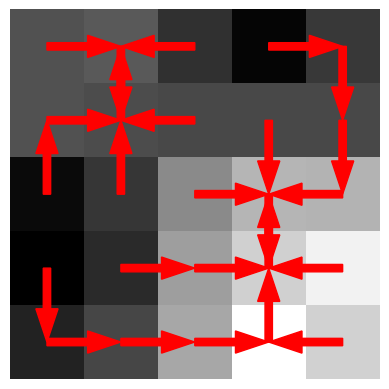

In [183]:
mc_values = algo.get_values()
mc_policy = algo.get_policy()

walk.display_policy(mc_policy)
walk.display_values(mc_values)

### Test TD learning on Walk:


In [184]:
walk = Walk()

algo = TDLearning(walk, policy="random", gamma=0.9)

n_episodes = 100
td_values_array = []
for t in range(n_episodes):
    algo.update_values()
    td_values_array.append(algo.get_values())

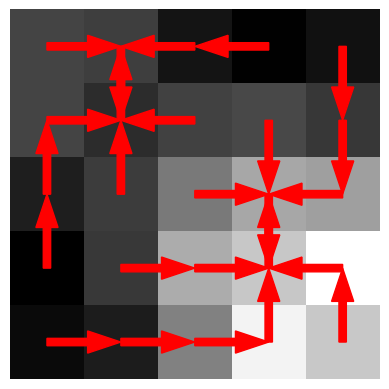

In [185]:
td_values = algo.get_values()
td_policy = algo.get_policy()

walk.display_policy(td_policy)
walk.display_values(td_values)

### Compare TD and MC with the exact solution:


In [186]:
wak = Walk()

algo = PolicyEvaluation(walk, gamma=0.9)
exact_policy = algo.get_policy()
algo.evaluate_policy()
exact_values = algo.values

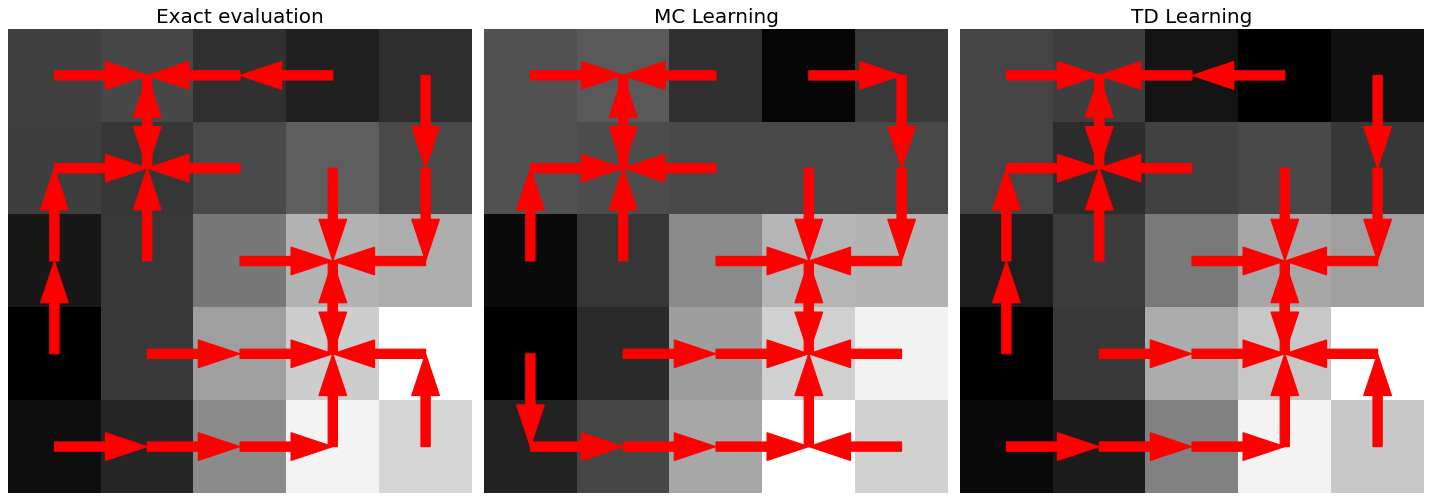

In [187]:
fig, axs = plt.subplots(1, 3, figsize=(18, 8), dpi=80)

plt.subplot(1, 3, 1)
walk.display_policy(exact_policy)
walk.display_values(exact_values)
axs[0].set_title("Exact evaluation", fontsize=18)
axs[0].axis("off")

plt.subplot(1, 3, 2)
walk.display_policy(mc_policy)
walk.display_values(mc_values)
axs[1].set_title("MC Learning", fontsize=18)
axs[1].axis("off")

plt.subplot(1, 3, 3)
walk.display_policy(td_policy)
walk.display_values(td_values)
axs[2].set_title("TD Learning", fontsize=18)
axs[2].axis("off")

plt.tight_layout()

### Spearman correlation for the two methods:


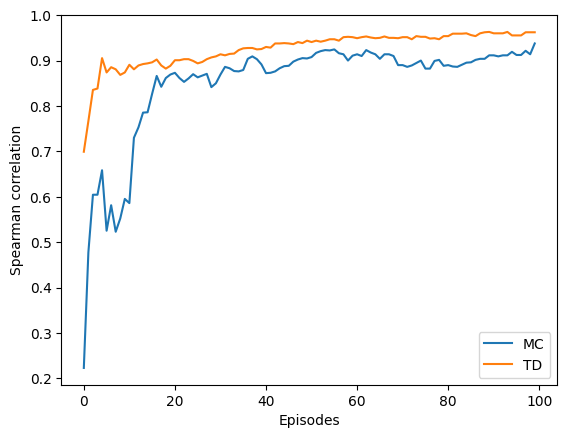

In [188]:
from scipy.stats import spearmanr

spearman_td = [spearmanr(opt_values, values).statistic for values in td_values_array]
spearman_mc = [spearmanr(opt_values, values).statistic for values in mc_values_array]

plt.figure()
plt.plot(spearman_mc, label="MC")
plt.plot(spearman_td, label="TD")
plt.xlabel("Episodes")
plt.ylabel("Spearman correlation")
plt.legend()
plt.show()

## To do:

Test the other environments:

- The maze: can you find the exit after policy improvement?<br> You might adapt the number of episodes used for training.
- The games (Tic-Tac-Toe, Nim, Connect Four): can you beat a random player after policy improvement? a player with the one-step policy?<br> Comment the results.


## Maze:


In [189]:
maze_map = np.load("../lib/maze.npy")

init_state = (1, 0)
exit_state = (1, 20)
Maze.set_parameters(maze_map, init_state, [exit_state])

### Test Monte-Carlo learning on Maze:


In [190]:
maze = Maze()

algo = MCLearning(maze, policy="random", gamma=0.9)

n_episodes = 2000
for t in range(n_episodes):
    algo.update_values(state="random")

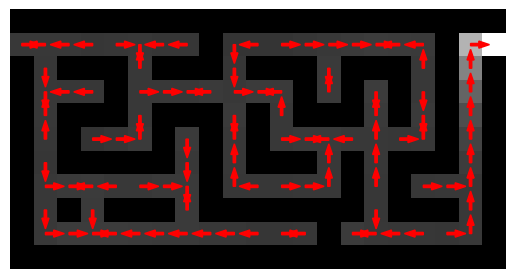

In [191]:
values = algo.get_values()
policy = algo.get_policy()

maze.display_policy(policy)
maze.display_values(values)

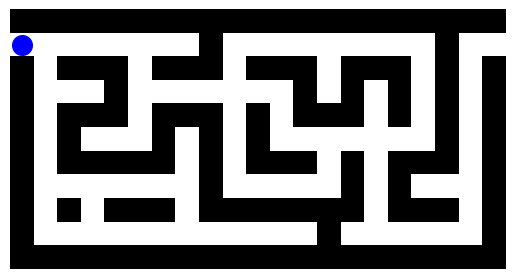

In [192]:
agent = Agent(maze, policy)
stop, states, rewards = agent.get_episode()
animation = maze.display(states)

In [193]:
animation

### Test TD learning on Maze:


In [194]:
maze = Maze()

algo = TDLearning(maze, policy="random", gamma=0.9)

n_episodes = 2000
for t in range(n_episodes):
    algo.update_values(state="random")

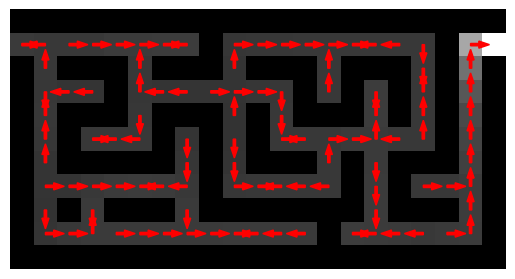

In [195]:
values = algo.get_values()
policy = algo.get_policy()

maze.display_policy(policy)
maze.display_values(values)

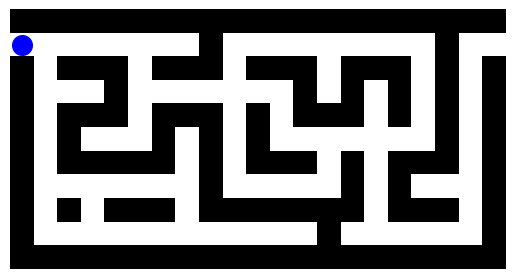

In [196]:
agent = Agent(maze, policy)
stop, states, rewards = agent.get_episode(horizon=500)
animation = maze.display(states)

In [197]:
animation

### Comments:


Even after policy improvement (both with MC and TD), the agent is not able to find the exit. This is due to the fact that the agent is not able to explore the environment enough to find the exit. The agent is stuck in a loop and is thus not able to find the exit.


## Games:


### Tic-Tac-Toe:


### Random player:


In [198]:
game = TicTacToe()

### Monte-Carlo learning:


In [199]:
algo = MCLearning(game, policy="random", gamma=0.9)

n_episodes = 2000
for t in range(n_episodes):
    algo.update_values()

policy = algo.get_policy()
agent = Agent(game, policy)

np.unique(agent.get_gains(), return_counts=True)

(array([-1,  0,  1]), array([ 2,  4, 94]))

### TD learning:


In [200]:
algo = TDLearning(game, policy="random", gamma=0.9)

n_episodes = 2000
for t in range(n_episodes):
    algo.update_values()

policy = algo.get_policy()
agent = Agent(game, policy)

np.unique(agent.get_gains(), return_counts=True)

(array([-1,  0,  1]), array([ 1,  2, 97]))

### Player with the one-step policy:


In [201]:
game = TicTacToe(adversary_policy="one_step")

### Monte-Carlo learning:


In [202]:
algo = MCLearning(game, policy="random", gamma=0.9)

n_episodes = 2000
for t in range(n_episodes):
    algo.update_values()

policy = algo.get_policy()
agent = Agent(game, policy)

np.unique(agent.get_gains(), return_counts=True)

(array([-1,  0,  1]), array([ 3, 37, 60]))

### TD learning:


In [203]:
algo = TDLearning(game, policy="random", gamma=0.9)

n_episodes = 2000
for t in range(n_episodes):
    algo.update_values()

policy = algo.get_policy()
agent = Agent(game, policy)

np.unique(agent.get_gains(), return_counts=True)

(array([-1,  0,  1]), array([29, 37, 34]))

### Comments:


The agent is able to beat the random player after both policy improvement.

However, when facing a player with the one-step policy, the results are not as good. The agent is not able to reliably beat (> 80% wr) the one-step policy player.

We can see that Monte-Carlo learning is able to beat the one-step policy player more often than TD learning.


### Nim:


In [204]:
game = Nim()

### Monte-Carlo learning:


In [205]:
algo = MCLearning(game, policy="random", gamma=0.9)

n_episodes = 2000
for t in range(n_episodes):
    algo.update_values()

policy = algo.get_policy()
agent = Agent(game, policy)

np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([ 5, 95]))

### TD learning:


In [206]:
algo = TDLearning(game, policy="random", gamma=0.9)

n_episodes = 2000
for t in range(n_episodes):
    algo.update_values()

policy = algo.get_policy()
agent = Agent(game, policy)

np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([ 7, 93]))

### Player with the one-step policy:


In [207]:
game = Nim(adversary_policy="one_step")

### Monte-Carlo learning:


In [208]:
algo = MCLearning(game, policy="random", gamma=0.9)

n_episodes = 2000
for t in range(n_episodes):
    algo.update_values()

policy = algo.get_policy()
agent = Agent(game, policy)

np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([ 9, 91]))

### TD learning:


In [209]:
algo = TDLearning(game, policy="random", gamma=0.9)

n_episodes = 2000
for t in range(n_episodes):
    algo.update_values()

policy = algo.get_policy()
agent = Agent(game, policy)

np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([ 8, 92]))

### Comments:


Here we can see that the agent is able to beat the adversary player with the random policy and one-step policy after both policy improvement.


### Connect Four:


In [210]:
game = ConnectFour()

### Monte-Carlo learning:


In [211]:
algo = MCLearning(game, policy="random", gamma=0.9)

n_episodes = 200
for t in range(n_episodes):
    algo.update_values()

policy = algo.get_policy()
agent = Agent(game, policy)

np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([ 8, 92]))

### TD learning:


In [212]:
algo = TDLearning(game, policy="random", gamma=0.9)

n_episodes = 200
for t in range(n_episodes):
    algo.update_values()

policy = algo.get_policy()
agent = Agent(game, policy)

np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([16, 84]))

### Player with the one-step policy:


In [213]:
game = ConnectFour(adversary_policy="one_step")

### Monte-Carlo learning:


In [214]:
algo = MCLearning(game, policy="random", gamma=0.9)

n_episodes = 200
for t in range(n_episodes):
    algo.update_values()

policy = algo.get_policy()
agent = Agent(game, policy)

np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([79, 21]))

### TD learning:


In [215]:
algo = TDLearning(game, policy="random", gamma=0.9)

n_episodes = 200
for t in range(n_episodes):
    algo.update_values()

policy = algo.get_policy()
agent = Agent(game, policy)

np.unique(agent.get_gains(), return_counts=True)

(array([-1,  1]), array([76, 24]))

### Comments:


Similarly to the Tic-Tac-Toe game, the agent is able to beat the adversary player with the random policy after both policy improvement, but not the one-step policy player.
